In [1]:
import math 
from math import floor, exp, sqrt, pi
import cmath 
import numpy 
import matplotlib.pyplot as plt
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace

import scipy
from scipy import special
import numpy as np 
import time
import scipy.signal
from numpy.fft import rfft, irfft
import os
import sys
import socket
import multiprocessing as mp

from scipy.interpolate import interp1d

In [2]:
#prefs.codegen.target = 'cython'

start_time = time.time()
par = int()

In [3]:
############### Accesory functions
###############


def decode_rE(rE, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    angles= np.arange(0,2*pi,2*np.pi/N) 
    R = np.sum(np.dot(np.reshape(rE, (1,N)),np.exp(1j*angles)))/np.sum(rE) ## population vector 
    angle_decoded = np.degrees(np.angle(R))
    strength_code = np.abs(R)
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded 
    
    return angle_decoded, strength_code


def model_I0E_constant(value, N=512): 
    y=[value for x in range(N)] 
    return np.reshape(np.array(y), (N,1)) 

In [4]:
############### MODEL STPA function
###############


def model_STPA(totalTime, targ_onset1, presentation_period, delay1,iti,angle_pos= random.random()*360, RV=1, 
    tauE=60, tauI=10, tauf=7000, taud=80, I0E=0.6, I0I=0.4, U=0.4, Gad=0.001, gadapt=0.5, tauad=1500,
    GEE=0.016, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
    kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
    N=512, save_RE=True):
    
        # Task timings converted to simulation steps
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt)); 
    origin = np.radians(angle_pos) 
    targ_offset1 = targ_onset1 + presentation_period; 
    targon1 = floor(targ_onset1/dt);
    targoff1 = floor(targ_offset1/dt); 
    resp_onset = targ_offset1 + delay1 ; 
    resp_offset = resp_onset + presentation_period;
    respon = floor (resp_onset/dt);
    respoff = floor( resp_offset/dt);
        ###### Definition of the network connectivity WE and WI
    v_E=np.zeros((N)); 
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta =np.arange(0,2*pi,2*pi/N) 
    v_E_new=[e**(kappa_E*np.cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]  # use a translationally invariant von Mises function to define the ring connectivity
    v_I_new=[e**(kappa_I*np.cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] 
    
    for i in range(0, N):
        #    
        vE_NEW=np.roll(v_E_new,i) 
        vI_NEW=np.roll(v_I_new,i) 
        # 
        WE[:,i]=vE_NEW 
        WI[:,i]=vI_NEW
        
    ###### Definition of the current corresponding to stimulus 1: target     
    target=np.zeros((N)) 
    for i in range(0, N):
        target[i]=RV*(e**(kappa_stim*cos(theta[i] - origin ))  / (2*pi*scipy.special.i0(kappa_stim)))
    #
    noise_stim = np.random.normal(0, 0.01, N) 
    target = target+ noise_stim
    target=reshape(target, (N,1)) 
     
    ###### Initialize all the variables for the simulation
    mf=1
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    s1 = np.zeros((N,1));
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    a = np.ones((N,1))*0.002 #a = np.zeros((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    SE=np.zeros((N,nsteps));
    AD=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    ###
    ###
    ### input-output function converting currents into firing rates, to be used during the simulation
    fnc = lambda x : x*x*(x>0)*(x<1) + array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real * (x>=1)
    xx=np.linspace(-5,10,100)
    yy=fnc(xx)
    func = interp1d(xx,yy, fill_value='extrapolate') # convert function into interpolated lookup table to make simulations much faster

        ### MAIN SIMULATION LOOP 
        # for each time step
    for i in range(0, nsteps):
        # independent noise to each neuron at each time step
        noiseE = sigE*random.randn(N,1);  
        noiseI = sigI*random.randn(N,1);
    
        # calculate the current inputs to each neuron based on the firing rates and the connectivity
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) - Gad * a + I0E; 
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1)); 
        
        ## consider additional inputs based on the task period: stimuli, response
        ## presentation stim 1
        if i>targon1 and i<targoff1:
            IE=IE+target;
            II=II+target;
        ## response 
        if i>respon and i<respoff: 
            IE = IE - 5 # hyperpolarize all neurons to stop the bumps
            II = II - 5 

    
        
        # Euler method applied to the differential rate equations, for each population
        rE = rE + (func(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (func(II) - rI + noiseI)*dt/tauI;

        # Euler method applied to the differential equations of synaptic plasticity: paper mongillo, barak, tsodyks. Science 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;

        # Euler method applied to the differential equation of the adaptation current a
        a = a + (-a/tauad + gadapt * rE/1000) * dt

        ur=np.reshape(u, N)
        xr=np.reshape(x, N)

        #append results to arrays 
        RE[:,i] = np.reshape(rE, N);
        RI[:,i] = np.reshape(rI, N);
        p_u[:,i] = ur;
        p_x[:,i] = xr;
        SE[:,i]= ur*xr;
        AD[:,i] = np.reshape(a,N)
    #### Decode positions
    final_position_bump, final_strength = decode_rE(RE[:,-5], N)
    previous_position_bump, previous_strength =decode_rE(RE[:,respon-1], N) 


    #p_targ = int((N * np.degrees(origin))/360) 

     
    ### Output
    ###return bias_target, bias_dist, number_of_bumps, angle_separation, RE #rE[p_targ][0], I0E
    if save_RE==True:
        return RE, WE , SE, AD
    else:
        return RE, WE , SE, AD   

In [5]:
    #####
    ##### Codes to run simulations
    #####
    Angle_pres1 = 120 #degrees 
    target_onset1 = 1500 #ms
    presentation_period = 250 #ms
    target_offset1 = target_onset1 + presentation_period 
    delay1= np.random.choice([1,2])*1000  #1500
    resp_onset = target_offset1 + delay1 
    resp_offset = resp_onset + presentation_period 
    iti = np.random.choice([1,2])*1000 #ms
    time_simulation=target_offset1 + delay1
    saveRE = True

In [6]:
GEEs=np.arange(0.0200,0.0300,0.000235)

In [7]:
tuning_values=[]
for GEE in GEEs:
    RV=1
    results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=Angle_pres1,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=512,save_RE=saveRE)
    if saveRE==True:
        RE = results[0]
        
    tuning=np.max(RE[:,-1])-np.abs(np.min(RE[:,-1]))
    tuning_values.append(tuning)

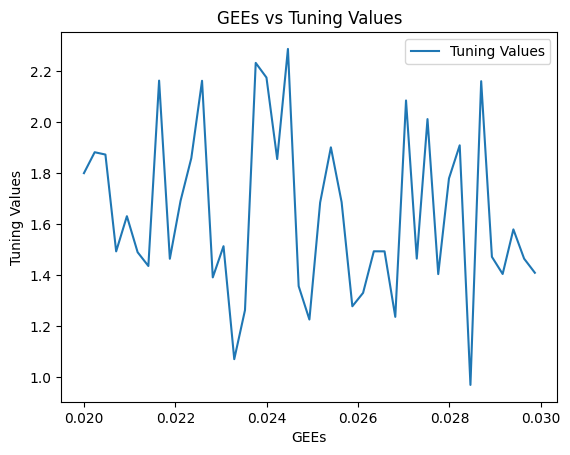

In [8]:
plt.plot(GEEs, tuning_values, label='Tuning Values')
plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title('GEEs vs Tuning Values')
plt.legend()
plt.show()

In [9]:
tuning_values_zero=[]
for GEE in GEEs:
    RV=0
    results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=Angle_pres1,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=512,save_RE=saveRE)
    if saveRE==True:
        RE0 = results[0]
        
    tuning_zero=np.max(RE0[:,-1])-np.abs(np.min(RE0[:,-1]))
    tuning_values_zero.append(tuning_zero)

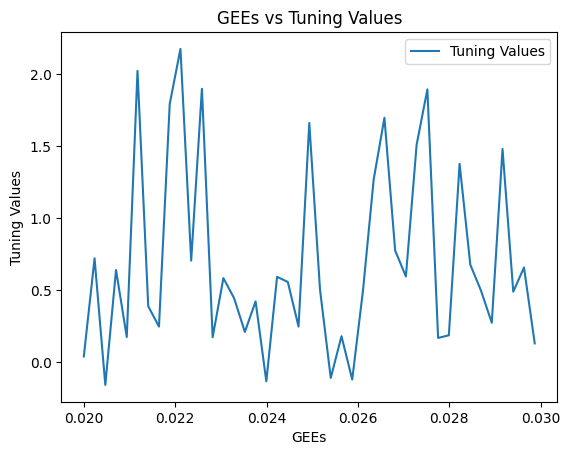

In [10]:
plt.plot(GEEs, tuning_values_zero, label='Tuning Values')
plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title('GEEs vs Tuning Values')
plt.legend()
plt.show()

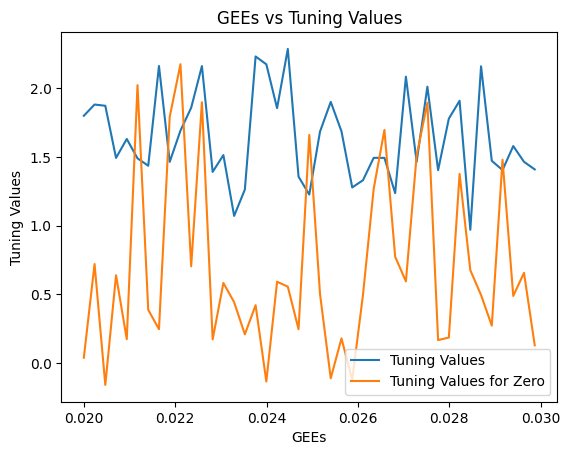

In [11]:
plt.plot(GEEs, tuning_values, label='Tuning Values')
plt.plot(GEEs, tuning_values_zero, label='Tuning Values for Zero')
plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title('GEEs vs Tuning Values')
plt.legend()
plt.show()

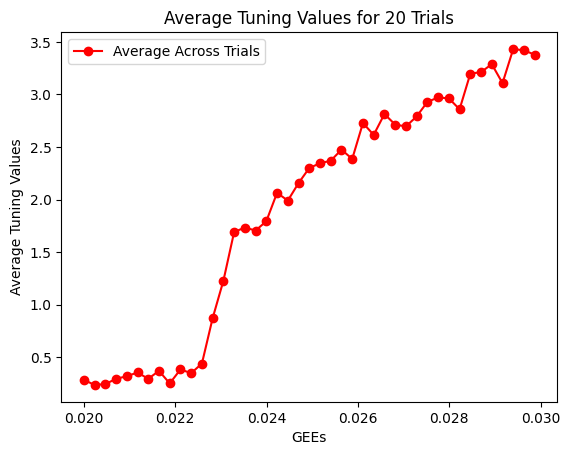

In [12]:




GEEs = np.arange(0.0200,0.0300,0.000235)

# Number of trials
num_trials = 20


all_tuning_values= []
# Number of trials
num_trials = 20
GEEs = np.arange(0.0200,0.0300,0.000235)
# Initialize an empty list to store average tuning values across trials for each GEE
all_tuning_values = []


for trial in range(num_trials):

    tuning_values = []

    for GEE_value in GEEs:
        RV=1
        results = model_STPA(totalTime=time_simulation, presentation_period=presentation_period,
                             targ_onset1=target_onset1, angle_pos=Angle_pres1, RV=RV, delay1=delay1, iti=iti,
                             tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
                             I0I=0.4, U=0.9, Gad=1, gadapt=0.01, tauad=1500,
                             GEE=GEE_value, GEI=0.019, GIE=0.01, GII=0.1,
                             sigE=4, sigI=2.2,
                             kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
                             N=512, save_RE=saveRE)

        if saveRE:
            RE = results[0]

        # Calculate tuning and store it in the list
        tuning = np.max(RE[:, -1]) - np.abs(np.min(RE[:, -1]))
        tuning_values.append(tuning)
    
    # Append the tuning values for the current trial to the list
    all_tuning_values.append(tuning_values)
    
 # Create an array to store the average tuning values for each GEE value
average_tuning_values = np.zeros(len(GEEs))

# Calculate the average tuning values across all trials for each GEE value
for tuning_values in all_tuning_values:
    average_tuning_values += np.array(tuning_values)

average_tuning_values /= num_trials
   
 
# Plot GEEs against the average tuning values
plt.plot(GEEs, average_tuning_values, marker='o', label='Average Across Trials', color='red')
plt.xlabel('GEEs')
plt.ylabel('Average Tuning Values')
plt.title(f'Average Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()






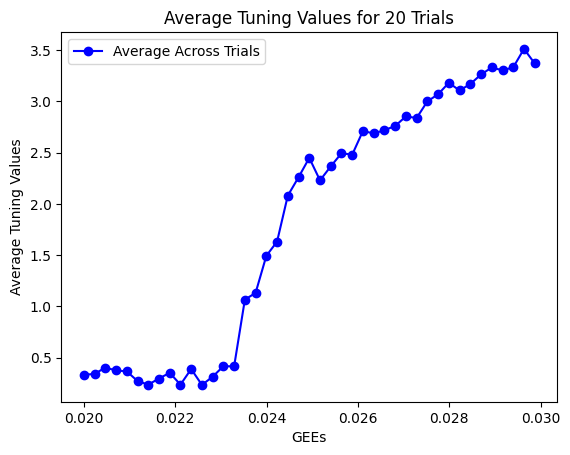

In [19]:



GEEs = np.arange(0.0200,0.0300,0.000235)

# Number of trials
num_trials = 20


GEEs = np.arange(0.0200,0.0300,0.000235)
all_tuning_valuesforzero= []


for trial in range(num_trials):
    
    tuning_valuesforzero = []
    

    for GEE_value in GEEs:
        RV=0
        results = model_STPA(totalTime=time_simulation, presentation_period=presentation_period,
                             targ_onset1=target_onset1, angle_pos=Angle_pres1, RV=RV, delay1=delay1, iti=iti,
                             tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
                             I0I=0.4, U=0.9, Gad=1, gadapt=0.01, tauad=1500,
                             GEE=GEE_value, GEI=0.019, GIE=0.01, GII=0.1,
                             sigE=4, sigI=2.2,
                             kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
                             N=512, save_RE=saveRE)

        if saveRE:
            RE0 = results[0]

        # Calculate tuning and store it in the list
        tuningzero = np.max(RE0[:, -1]) - np.abs(np.min(RE0[:, -1]))
        tuning_valuesforzero.append(tuningzero)
    
    # Append the tuning values for the current trial to the list
    all_tuning_valuesforzero.append(tuning_valuesforzero)
    
# Create an array to store the average tuning values for each GEE value
average_tuning_valuesforzero = np.zeros(len(GEEs))

# Calculate the average tuning values across all trials for each GEE value
for tuning_valuesforzero in all_tuning_valuesforzero:
    average_tuning_valuesforzero += np.array(tuning_valuesforzero)

average_tuning_valuesforzero /= num_trials

# Plot GEEs against the average tuning values
plt.plot(GEEs, average_tuning_valuesforzero, marker='o', label='Average Across Trials', color='blue')
plt.xlabel('GEEs')
plt.ylabel('Average Tuning Values')
plt.title(f'Average Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()


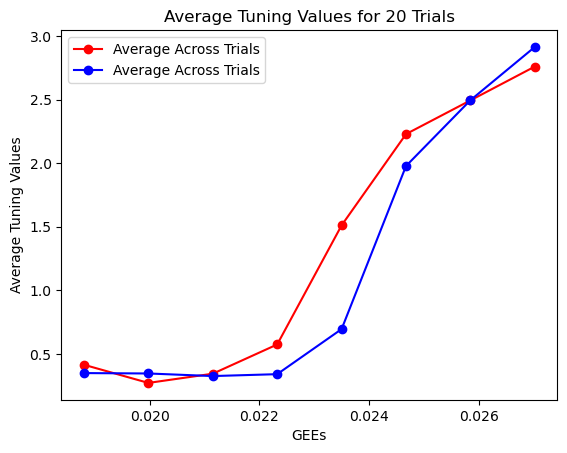

In [ ]:
plt.plot(GEEs, average_tuning_values, marker='o', label='Average Across Trials', color='red')
plt.plot(GEEs, average_tuning_valuesforzero, marker='o', label='Average Across Trials', color='blue')
plt.xlabel('GEEs')
plt.ylabel('Average Tuning Values')
plt.title(f'Average Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()


In [25]:

GEEs = np.arange(0.0200,0.0300,0.000235)

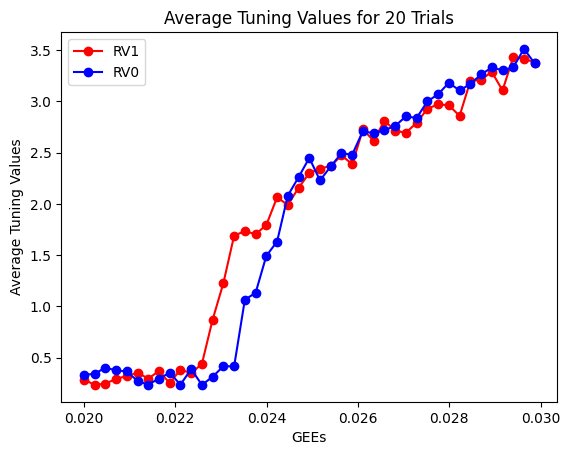

In [26]:
plt.plot(GEEs, average_tuning_values, marker='o', label='RV1', color='red')
plt.plot(GEEs, average_tuning_valuesforzero, marker='o', label='RV0', color='blue')
plt.xlabel('GEEs')
plt.ylabel('Average Tuning Values')
plt.title(f'Average Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()

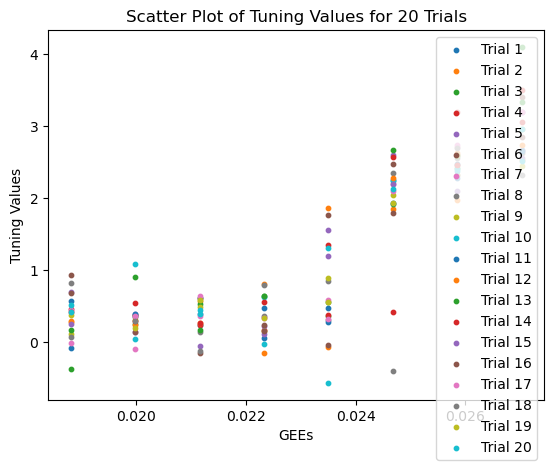

In [ ]:

GEEs = np.arange(0.0188,0.0282,0.001175)

for i, tuning_valuesforzero in enumerate(all_tuning_valuesforzero):
    plt.scatter(GEEs, tuning_valuesforzero, label=f'Trial {i+1}', s=10)

plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title(f'Scatter Plot of Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()

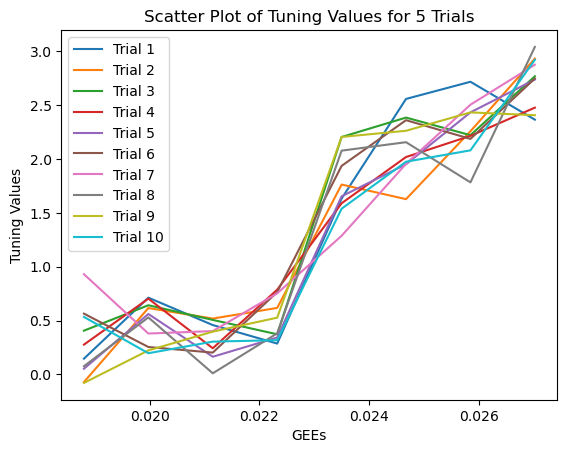

In [ ]:
for i, tuning_values in enumerate(all_tuning_values):
    plt.plot(GEEs, tuning_values, label=f'Trial {i+1}')

plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title(f'Scatter Plot of Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()

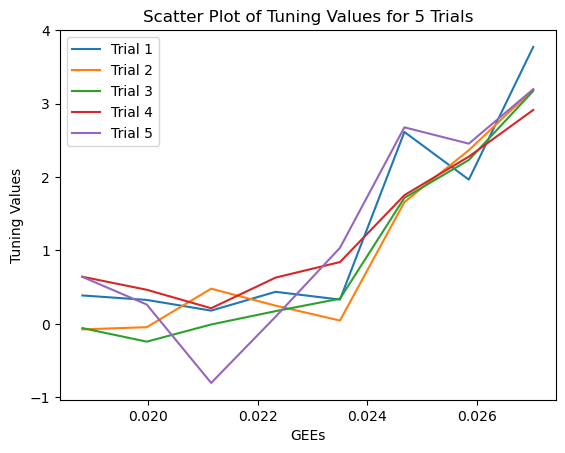

In [ ]:
for i, tuning_valuesforzero in enumerate(all_tuning_valuesforzero):
    plt.plot(GEEs, tuning_valuesforzero, label=f'Trial {i+1}')

plt.xlabel('GEEs')
plt.ylabel('Tuning Values')
plt.title(f'Scatter Plot of Tuning Values for {num_trials} Trials')
plt.legend()
plt.show()

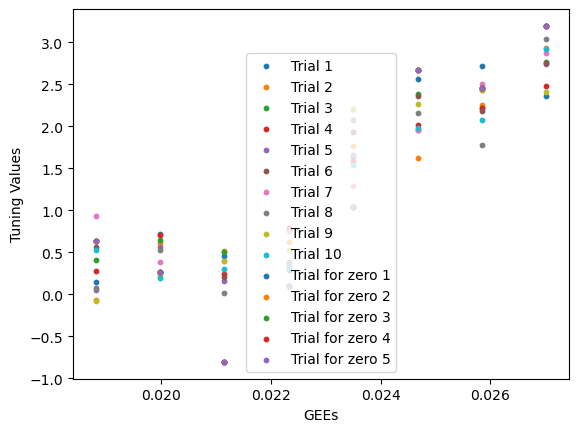

In [ ]:

GEEs = np.arange(0.0188,0.0282,0.001175)
for i, tuning_values in enumerate(all_tuning_values):
    plt.scatter(GEEs, tuning_values, label=f'Trial {i+1}', s=10)
for i, tuning_values in enumerate(all_tuning_valuesforzero):
    plt.scatter(GEEs, tuning_valuesforzero, label=f'Trial for zero {i+1}', s=10)
plt.xlabel('GEEs')
plt.ylabel('Tuning Values')

plt.legend()
plt.show()

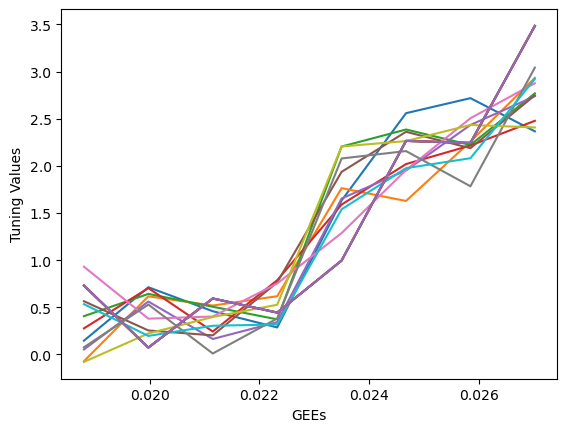

In [ ]:

GEEs = np.arange(0.0188,0.0282,0.001175)
for i, tuning_values in enumerate(all_tuning_values):
    plt.plot(GEEs, tuning_values, label=f'Trial {i+1}')
for i, tuning_values in enumerate(all_tuning_valuesforzero):
    plt.plot(GEEs, tuning_valuesforzero, label=f'Trial for zero {i+1}')
plt.xlabel('GEEs')
plt.ylabel('Tuning Values')

#plt.legend()
plt.show()